In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from chinese_calendar import is_workday,is_holiday
import chinese_calendar as calendar 
import time,datetime
from scipy import stats 
import matplotlib.pyplot as plt
 
 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
#配色 
colors=['gold','saddlebrown','yellowgreen']

In [69]:
#读取数据
filepath='train_csv_4.04.csv'
data=pd.read_csv(filepath)
data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,year,month,day,day_of_week,is_weekend,is_holiday,sales_chan,season,ord_qty
0,2015-09-02,104,20028,301,405,offline,1005.0,2015,9,2,2,0,0,0,3,11
1,2015-09-03,102,20354,303,401,offline,1420.0,2015,9,3,3,0,1,0,3,64
2,2015-09-04,101,20586,306,407,offline,978.0,2015,9,4,4,0,1,0,3,7
3,2015-09-04,101,20230,306,407,offline,864.0,2015,9,4,4,0,1,0,3,66
4,2015-09-04,105,21619,306,402,online,274.0,2015,9,4,4,0,1,1,3,102


In [48]:
#得到产品大类的列表
first_cate_code_list=sorted(list(data['first_cate_code'].drop_duplicates()))
first_cate_len=len(first_cate_code_list)
print(first_cate_code_list)
#将其与一个坐标映射起来
f_index=0
first_cate_code_dict={}
second_cate_code_dict={}
for i in first_cate_code_list:
    first_cate_code_dict[str(i)]=f_index
    f_index+=1
#得到产品细类的列表
second_cate_code_list=sorted(list(data['second_cate_code'].drop_duplicates()))
second_cate_len=len(second_cate_code_list)
s_index=0
print(second_cate_code_list)
for i in second_cate_code_list:
    second_cate_code_dict[str(i)]=s_index
    s_index+=1

[301, 302, 303, 304, 305, 306, 307, 308]
[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]


In [50]:
second_cate_code_dict

{'401': 0,
 '402': 1,
 '403': 2,
 '404': 3,
 '405': 4,
 '406': 5,
 '407': 6,
 '408': 7,
 '409': 8,
 '410': 9,
 '411': 10,
 '412': 11}

# 产品所在区域对需求量的影响，以及不同区域的产品需求量有何特性；

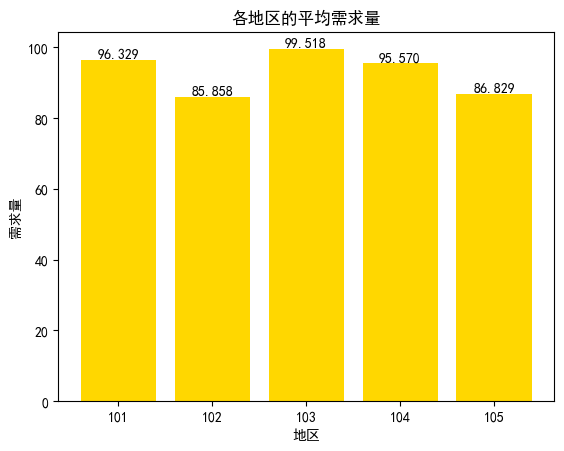

In [275]:
#统计不同地区的平均需求量
region_data=data.groupby('sales_region_code').mean('ord_qty')
region_ord_qty=region_data['ord_qty']
# list(region_ord_qty)
region_code=list(region_data.index)
plt.bar(region_code,region_ord_qty,color=colors[0])
plt.xlabel('地区')
plt.ylabel('需求量')
plt.title("各地区的平均需求量")
for x,y in zip(region_code,region_ord_qty):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()


In [170]:
#得到地区的编码
region_code

[101, 102, 103, 104, 105]

不同地区产品大类销量前3

In [211]:

region_first=data.groupby(['sales_region_code','first_cate_code'],as_index=False).mean('ord_qty')
region_first=region_first.sort_values(by=['sales_region_code','ord_qty'], ascending=[False,False])
region_first=region_first.groupby(['sales_region_code'],as_index=False).head(3)
region_first=region_first[['sales_region_code','first_cate_code','ord_qty']]
region_first=pd.DataFrame(region_first)
region_first.to_csv("不同地区产品大类平均需求量前三.csv",index=False)
region_first_dict={}
for index,row in region_first.iterrows():
    region=row['sales_region_code']
    cate_code=row['first_cate_code']
    ord_qty=row['ord_qty']
    if region_first_dict.get(region)==None:
        region_first_dict[region]={}
    region_first_dict[region][cate_code]=ord_qty
    # print(row['sales_region_code'],row['first_cate_code'],row['ord_qty'])
region_first_dict

{105.0: {306.0: 96.55534836412951,
  308.0: 95.22517730496453,
  307.0: 85.45477545857052},
 104.0: {308.0: 110.85696040868454,
  307.0: 103.65980498374864,
  301.0: 82.58901830282862},
 103.0: {307.0: 130.96594778660614,
  306.0: 126.41148886283705,
  308.0: 123.72822665267576},
 102.0: {306.0: 116.09613259668508,
  308.0: 114.3715308863026,
  307.0: 113.64625850340136},
 101.0: {307.0: 143.8074369189907,
  308.0: 128.53551296505074,
  306.0: 111.72723928637116}}

不同地区产品细类销量前3

In [272]:

region_second=data.groupby(['sales_region_code','second_cate_code'],as_index=False).mean('ord_qty')
region_second=region_second.sort_values(by=['sales_region_code','ord_qty'], ascending=[False,False])
region_second=region_second.groupby(['sales_region_code'],as_index=False).head(3)
region_second=region_second[['sales_region_code','second_cate_code','ord_qty']]
region_second=pd.DataFrame(region_second)
region_second
# region_second.to_csv("不同地区产品细类平均需求量前三.csv",index=False)
region_second_dict={}
for index,row in region_second.iterrows():
    region=row['sales_region_code']
    cate_code=row['second_cate_code']
    ord_qty=row['ord_qty']
    if region_second_dict.get(region)==None:
        region_second_dict[region]={}
    region_second_dict[region][cate_code]=ord_qty
    # print(row['sales_region_code'],row['first_cate_code'],row['ord_qty'])
region_second_dict

{105.0: {402.0: 208.95426195426197,
  401.0: 100.52266288951841,
  404.0: 95.22517730496453},
 104.0: {404.0: 110.85696040868454,
  403.0: 103.65980498374864,
  405.0: 82.58901830282862},
 103.0: {402.0: 210.17808219178082,
  403.0: 130.96594778660614,
  404.0: 123.72822665267576},
 102.0: {402.0: 159.56906077348066,
  407.0: 114.81751706207345,
  404.0: 114.3715308863026},
 101.0: {402.0: 155.81944444444446,
  403.0: 143.8074369189907,
  404.0: 128.53551296505074}}

# 不同销售方式（线上和线下）的产品需求量的特性；
这里留个坑：2016年9月抖音上线，统计直播带货爆发后的影响

In [255]:
#统计不同销售方式的产品需求量

# plt.bar(['线下','线上'],sales_chan_ord_qty,width=0.5,color=colors[1])
# plt.xlabel('销售方式')
# plt.ylabel('需求量')
# plt.title("各销售方式的需求量")
# for x,y in zip(sales_chan,sales_chan_ord_qty):
#     plt.text(x,y,'%.0f'%y,ha='center',va='bottom',fontsize=7)
# plt.show()


[0, 1]


## 线上和线下平均需求量的分析
4.11：加上产品大类细类分析销售方式不同的差异

### 根据下面的平均需求量可得，每一单线上订单的平均需求量显著大于线下，所以可以适当扩大线上销售途径，增加线上的订单数
根据平均需求量可得线上的需求量显著大于线下销售渠道的需求量，可从这方面提高销量

In [262]:
sales_chan_data=data.groupby('sales_chan').sum('ord_qty')
sales_chan_ord_qty=sales_chan_data['ord_qty']
sales_chan=list(sales_chan_data.index)
print(sales_chan)

[0, 1]


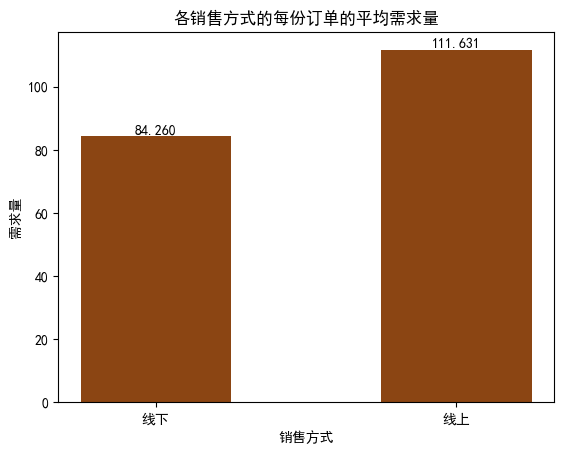

In [263]:
#平均需求量
chan_count=data.groupby('sales_chan').count()['ord_qty']
chan_count=np.array(chan_count)
sales_chan_ord_qty_mean=np.array(sales_chan_ord_qty/chan_count)
plt.bar(['线下','线上'],sales_chan_ord_qty_mean,width=0.5,color=colors[1])
plt.xlabel('销售方式')
plt.ylabel('需求量')
plt.title("各销售方式的每份订单的平均需求量")
for x,y in zip(sales_chan,sales_chan_ord_qty_mean):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()

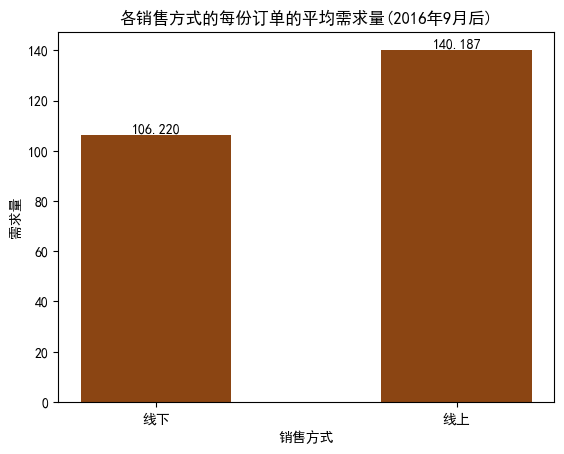

In [264]:
#平均需求量
chan_count=data[data.order_date>'2016-09-01'].groupby('sales_chan').count()['ord_qty']
chan_count=np.array(chan_count)

sales_chan_ord_qty_mean=np.array(sales_chan_ord_qty/chan_count)

plt.bar(['线下','线上'],sales_chan_ord_qty_mean,width=0.5,color=colors[1])
plt.xlabel('销售方式')
plt.ylabel('需求量')
plt.title("各销售方式的每份订单的平均需求量(2016年9月后)")
for x,y in zip(sales_chan,sales_chan_ord_qty_mean):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()

###  自媒体平台对平均需求量的影响 
2016年9月抖音等平台推出以来，直播带货使线上平均需求量与线下平均需求量的差距进一步增加，根据平均需求量差距的缩小，接下来探索具体到每一个月的线上线下平均销售量的差距

In [280]:

# 提取差值和日期
data_YM_sum=data.groupby(['year','month','sales_chan']).sum('ord_qty')["ord_qty"]
data_YM_count=data.groupby(['year','month','sales_chan']).count()['ord_qty']
data_YM_index=data_YM_sum.index
data_YM_sum=pd.DataFrame(data_YM_sum)
data_YM_count=pd.DataFrame(data_YM_count)
data_YM_mean=pd.DataFrame(data_YM_sum/data_YM_count)
# data_YM_mean=data.groupby(['year','month','sales_chan']).mean('ord_qty')

# print(data_YM_mean)
# data_YM_sum=np.array(data_YM_sum)
# data_YM_count=np.array(data_YM_count)
# print(data_YM_index,data_YM_sum,data_YM_count)
# print(data_YM_sum/data_YM_count)
data_YM_index=data.groupby(['year','month']).count().index
data_YM_ord=list(data_YM_mean['ord_qty'])
data_YM_chan_diff=[]
for i in range(0,len(data_YM_ord),2):
    data_YM_chan_diff.append(data_YM_ord[i+1]-data_YM_ord[i])
data_YM_index_list=[]
for i in data_YM_index:
    date=""
    date= str(i[0])+'-'+str(i[1])
    data_YM_index_list.append(date)

print(data_YM_chan_diff,data_YM_index_list)


[19.103635132083994, 88.71166892808685, 65.76636451106498, -3.563885379032712, 27.404040404040387, 9.099374499408825, -2.1300374902154573, -7.120785615350826, 44.357556792879706, -40.13754533754533, -6.62984005729291, -4.041929655787314, 40.836997465926984, 44.925454797442654, 23.823206301894828, 0.6083914925342242, 19.78624674249005, 20.986524417802514, -4.552827859148266, 13.452914499132987, 39.569203741277775, -30.31637024989945, 7.452589903336175, 15.067202171593934, 86.10697981771887, 77.89086264116705, 11.181638541971793, -24.43860934701189, 46.56470624473786, 5.232968874700717, 3.174922738813862, 15.562684565673294, 47.94836591578742, -3.1856141307457477, 7.984265297553563, 20.942491120139138, 48.78403429366228, 88.41693785236922, 54.499981987499325, 50.638669695520484] ['2015-9', '2015-10', '2015-11', '2015-12', '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6', '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017

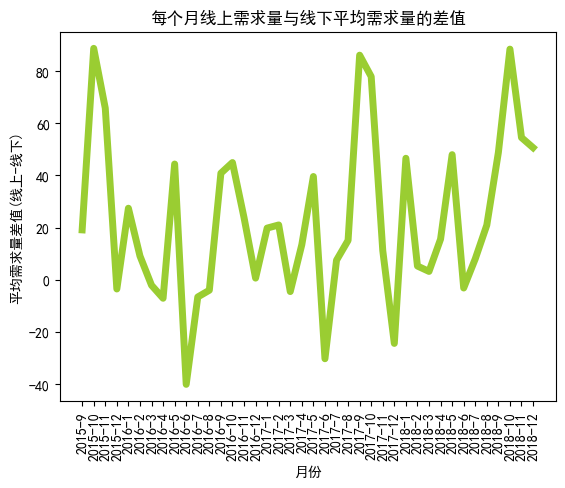

In [271]:
#绘制平均需求量差值折线图
plt.plot(data_YM_index_list,data_YM_chan_diff,color=colors[2],linewidth=5)
plt.xlabel('月份')
plt.ylabel('平均需求量差值(线上-线下)')
plt.title('每个月线上需求量与线下平均需求量的差值')
plt.xticks(rotation=90)
plt.show()
#可用于后面季节的分析，秋季线上销售的销售量更多于线下销售量，六月线下会多于线上（why？）

## 销售方式对产品大类和细类的影响

### 产品大类的平均需求量(线上线下)

8 8
[301, 302, 303, 304, 305, 306, 307, 308] [301, 302, 303, 304, 305, 306, 307, 308]
[50, 54, 45, 58, 75, 107, 115, 110] [88, 99, 129, 59, 105, 126, 104, 114]


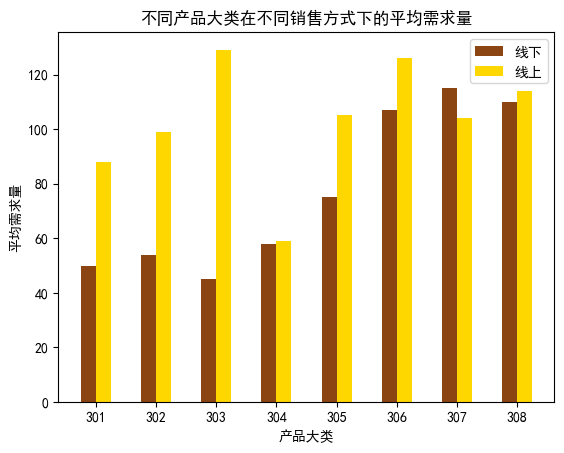

In [84]:
#产品大类的柱状图
chann_data_first=data[['sales_chan','first_cate_code','ord_qty']].groupby(['sales_chan','first_cate_code'],as_index=False).mean()
chann_data_first
x_first_0=first_cate_code_list
x_first_1=first_cate_code_list
# print(x_first)
y_first_0=[0 for i in range(first_cate_len)]
y_first_1=[0 for i in range(first_cate_len)]
for index,item in chann_data_first.iterrows():
    chann=item['sales_chan']
    cate_code=str(int(item['first_cate_code']))
    qty=int(item['ord_qty'])
    if(chann==0):
        y_first_0[first_cate_code_dict[cate_code]]=qty
    elif(chann==1):
         y_first_1[first_cate_code_dict[cate_code]]=qty
    # print(chann,cate_code,qty)
    # print(chann)
print(len(x_first_0),len(x_first_1))
print(x_first_0,x_first_1)
print(y_first_0,y_first_1)
wid=0.25
x=2
# plt.bar(x_first_0,y_first_0)
# plt.bar(x_first_1,y_first_1)
x = np.arange(len(x_first_0))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, y_first_0, width, label='线下',color=colors[1])
plt.bar(x + width/2, y_first_1, width, label='线上',color=colors[0])
plt.xticks(x,x_first_0)
plt.ylabel("平均需求量")
plt.xlabel("产品大类")
plt.title("不同产品大类在不同销售方式下的平均需求量")
plt.legend()
plt.show()

In [ ]:
# chann_data_first=data[['sales_chan','first_cate_code','ord_qty']].groupby(['sales_chan','first_cate_code'],as_index=False).mean()
# x_first_0=[]
# x_first_1=[]
# # print(x_first)
# y_first_0=[]
# y_first_1=[]
# for index,item in chann_data_first.iterrows():
#     chann=item['sales_chan']
#     cate_code=str(int(item['first_cate_code']))
#     qty=int(item['ord_qty'])
#     if(chann==0):
#         x_first_0.append(cate_code)
#         y_first_0.append(qty)
#     elif(chann==1):
#         x_first_1.append(cate_code)
#         y_first_1.append(qty)
#     # print(chann,cate_code,qty)
#     # print(chann)
# print(len(x_first_0),len(x_first_1))
# print(x_first_0,x_first_1)
# print(y_first_0,y_first_1)
# wid=0.25
# x=2
# # plt.bar(x_first_0,y_first_0)
# # plt.bar(x_first_1,y_first_1)
# x = np.arange(len(x_first_0))  # x轴刻度标签位置
# width = 0.25  # 柱子的宽度
# # 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# # x - width/2，x + width/2即每组数据在x轴上的位置
# plt.bar(x - width/2, y_first_0, width, label='线下')
# plt.bar(x + width/2, y_first_1, width, label='线上')
# plt.xticks(x,x_first_0)
# plt.ylabel("平均需求量")
# plt.xlabel("产品大类")
# plt.title("不同产品大类在不同销售方式下的平均需求量")
# plt.legend()
# plt.show()

### 产品细类的平均需求量(线上线下)
406 411没有线上订单

12 12
[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412] [401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]
[52, 160, 115, 110, 50, 8, 104, 54, 58, 14, 9, 75] [129, 237, 104, 114, 88, 0, 114, 99, 59, 5, 0, 105]


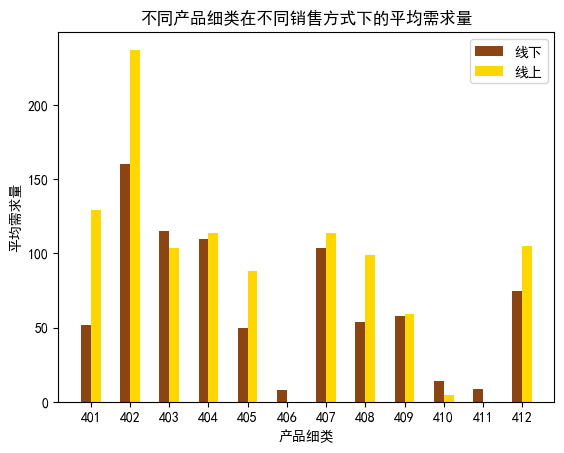

In [83]:
chann_data_second=data[['sales_chan','second_cate_code','ord_qty']].groupby(['sales_chan','second_cate_code'],as_index=False).mean()
chann_data_second
x_second_0=second_cate_code_list
x_second_1=second_cate_code_list
# print(x_second)
y_second_0=[0 for i in range(second_cate_len)]
y_second_1=[0 for i in range(second_cate_len)]
for index,item in chann_data_second.iterrows():
    chann=item['sales_chan']
    cate_code=str(int(item['second_cate_code']))
    qty=int(item['ord_qty'])
    if(chann==0):
        y_second_0[second_cate_code_dict[cate_code]]=qty
    elif(chann==1):
         y_second_1[second_cate_code_dict[cate_code]]=qty
    # print(chann,cate_code,qty)
    # print(chann)
print(len(x_second_0),len(x_second_1))
print(x_second_0,x_second_1)
print(y_second_0,y_second_1)
wid=0.25
x=2
# plt.bar(x_second_0,y_second_0)
# plt.bar(x_second_1,y_second_1)
x = np.arange(len(x_second_0))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, y_second_0, width, label='线下',color=colors[1])
plt.bar(x + width/2, y_second_1, width, label='线上',color=colors[0])
plt.xticks(x,x_second_0)
plt.ylabel("平均需求量")
plt.xlabel("产品细类")
plt.title("不同产品细类在不同销售方式下的平均需求量")
plt.legend()
plt.show()

# 不同种类之间的产品需求量有何不同点和共同点；
不同点和共同点可结合季节节假日地区等因素分析

统计产品销量前十名（根据产品编码）

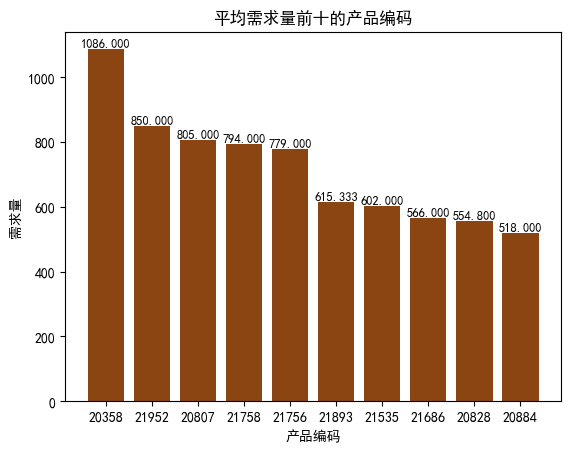

In [57]:
#统计产品销量前十名
item_code_data=data.groupby('item_code',as_index=False).mean('ord_qty').sort_values('ord_qty',ascending=False)[['item_code','ord_qty']].head(10)
item_code_x=list(item_code_data['item_code'])
item_code_y=list(item_code_data['ord_qty'])
item_code_x=[str(i) for i in item_code_x]
plt.bar(item_code_x,item_code_y,color=colors[1])
plt.xlabel('产品编码')
plt.ylabel('需求量')
plt.title("平均需求量前十的产品编码")
for x,y in zip(item_code_x,item_code_y):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=9)
plt.show()

# 节假日对产品需求量的影响；

In [58]:
data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,year,month,day,day_of_week,is_weekend,is_holiday,sales_chan,season,ord_qty
0,2015-09-02,104,20028,301,405,offline,1005.0,2015,9,2,2,0,0,0,3,11
1,2015-09-03,102,20354,303,401,offline,1420.0,2015,9,3,3,0,1,0,3,64
2,2015-09-04,101,20586,306,407,offline,978.0,2015,9,4,4,0,1,0,3,7
3,2015-09-04,101,20230,306,407,offline,864.0,2015,9,4,4,0,1,0,3,66
4,2015-09-04,105,21619,306,402,online,274.0,2015,9,4,4,0,1,1,3,102


In [59]:
item_code=data['item_code']
print(len(item_code))
len(item_code.drop_duplicates())

59769


1423

## 周一到周日的平均需求量
注意：这里2015-9-02判定为第二天，该日为星期三，外国为星期二
个人认为平均需求量更能反应一些规律，因为统计星期几的天数不同。

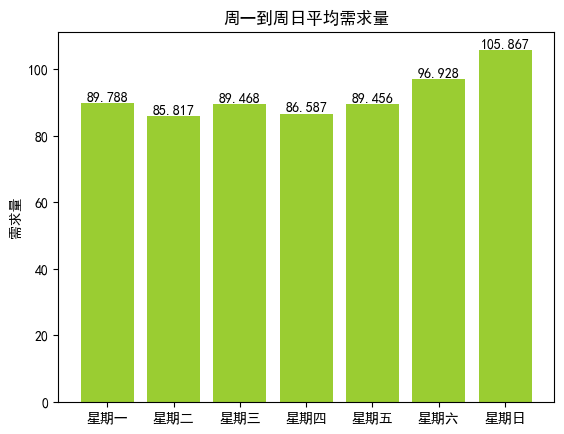

In [60]:
#周一到周日平均需求量
weekday=['星期一','星期二','星期三','星期四','星期五','星期六','星期日']
weekday_data=data[['day_of_week','ord_qty']]
weekday_data=weekday_data.groupby('day_of_week',as_index=False).mean()
weekday_data_x=[]
weekday_data_y=[]
for index,item in weekday_data.iterrows():
    weekday_data_x.append(weekday[int(item['day_of_week'])])
    weekday_data_y.append(item['ord_qty'])
plt.bar(weekday_data_x,weekday_data_y,color=colors[2])
plt.ylabel('需求量')
plt.title("周一到周日平均需求量")
for x,y in zip(weekday_data_x,weekday_data_y):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()

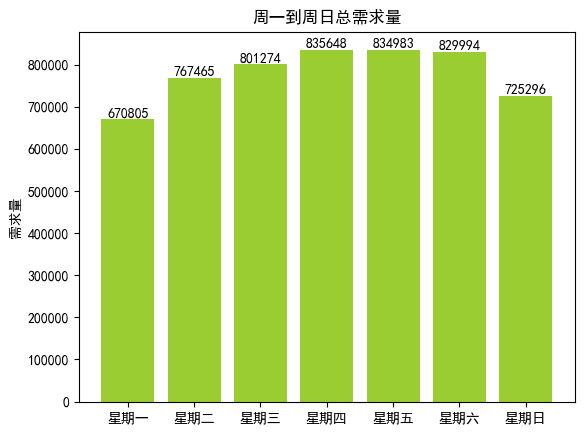

In [61]:
#周一到周日总需求量
# 求总需求量不是很合适
weekday_data=data[['day_of_week','ord_qty']]
weekday_data=weekday_data.groupby('day_of_week',as_index=False).sum()
weekday_data_x2=[]
weekday_data_y2=[]
for index,item in weekday_data.iterrows():
    weekday_data_x2.append(weekday[int(item['day_of_week'])])
    weekday_data_y2.append(item['ord_qty'])
plt.bar(weekday_data_x2,weekday_data_y2,color=colors[2])
plt.ylabel('需求量')
plt.title("周一到周日总需求量")
for x,y in zip(weekday_data_x2,weekday_data_y2):
    plt.text(x,y,'%.0f'%y,ha='center',va='bottom',fontsize=10)
plt.show()

## 周末和非周末的平均需求量
与节假日和非节假日有点重合，可选择其一

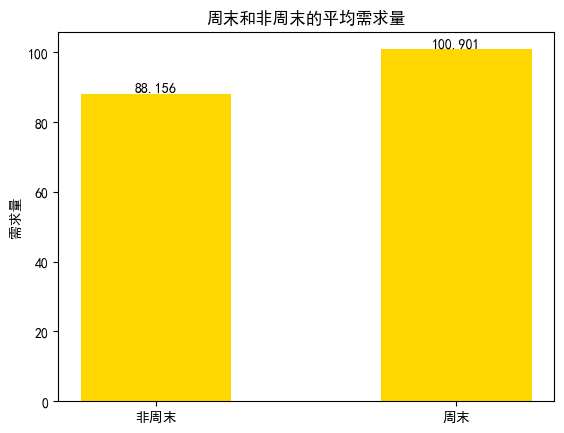

In [62]:
weekend_data=data[['is_weekend','ord_qty']].groupby('is_weekend').mean()
weekend_y=weekend_data['ord_qty']
plt.bar(['非周末','周末'],weekend_y,color=colors[0],width=0.5)
plt.ylabel('需求量')
plt.title("周末和非周末的平均需求量")
for x,y in zip(['非周末','周末'],weekend_y):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()

### 大类平均需求量

8 8
[301, 302, 303, 304, 305, 306, 307, 308] [301, 302, 303, 304, 305, 306, 307, 308]
[67, 62, 52, 56, 80, 108, 106, 104] [86, 72, 53, 66, 92, 121, 122, 136]


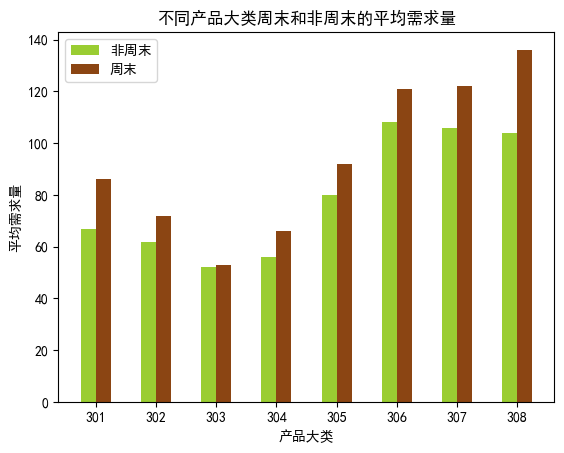

In [86]:
weekend_data_first=data[['is_weekend','first_cate_code','ord_qty']].groupby(['is_weekend','first_cate_code'],as_index=False).mean()
x_first_0=first_cate_code_list
x_first_1=first_cate_code_list
# print(x_first)
y_first_0=[0 for i in range(first_cate_len)]
y_first_1=[0 for i in range(first_cate_len)]
for index,item in weekend_data_first.iterrows():
    boolean=item['is_weekend']
    cate_code=str(int(item['first_cate_code']))
    qty=int(item['ord_qty'])
    if(boolean==0):
        y_first_0[first_cate_code_dict[cate_code]]=qty
    elif(boolean==1):
         y_first_1[first_cate_code_dict[cate_code]]=qty
    # print(chann,cate_code,qty)
    # print(chann)
print(len(x_first_0),len(x_first_1))
print(x_first_0,x_first_1)
print(y_first_0,y_first_1)
wid=0.25
x=2
# plt.bar(x_first_0,y_first_0)
# plt.bar(x_first_1,y_first_1)
x = np.arange(len(x_first_0))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, y_first_0, width, label='非周末',color=colors[2])
plt.bar(x + width/2, y_first_1, width, label='周末',color=colors[1])
plt.xticks(x,x_first_0)
plt.ylabel("平均需求量")
plt.xlabel("产品大类")
plt.title("不同产品大类周末和非周末的平均需求量")
plt.legend()
plt.show()

### 细类平均需求量

12 12
[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412] [401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]
[60, 190, 106, 104, 67, 8, 103, 62, 56, 13, 9, 80] [61, 187, 122, 136, 86, 9, 117, 72, 66, 15, 9, 92]


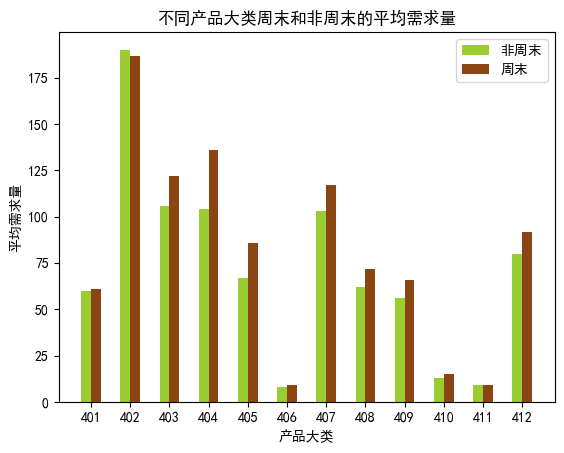

In [87]:
weekend_data_second=data[['is_weekend','second_cate_code','ord_qty']].groupby(['is_weekend','second_cate_code'],as_index=False).mean()
x_second_0=second_cate_code_list
x_second_1=second_cate_code_list
# print(x_second)
y_second_0=[0 for i in range(second_cate_len)]
y_second_1=[0 for i in range(second_cate_len)]
for index,item in weekend_data_second.iterrows():
    boolean=item['is_weekend']
    cate_code=str(int(item['second_cate_code']))
    qty=int(item['ord_qty'])
    if(boolean==0):
        y_second_0[second_cate_code_dict[cate_code]]=qty
    elif(boolean==1):
         y_second_1[second_cate_code_dict[cate_code]]=qty
    # print(chann,cate_code,qty)
    # print(chann)
print(len(x_second_0),len(x_second_1))
print(x_second_0,x_second_1)
print(y_second_0,y_second_1)
wid=0.25
x=2
# plt.bar(x_second_0,y_second_0)
# plt.bar(x_second_1,y_second_1)
x = np.arange(len(x_second_0))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, y_second_0, width, label='非周末',color=colors[2])
plt.bar(x + width/2, y_second_1, width, label='周末',color=colors[1])
plt.xticks(x,x_second_0)
plt.ylabel("平均需求量")
plt.xlabel("产品大类")
plt.title("不同产品大类周末和非周末的平均需求量")
plt.legend()
plt.show()

## 节假日和非节假日

### 平均需求量

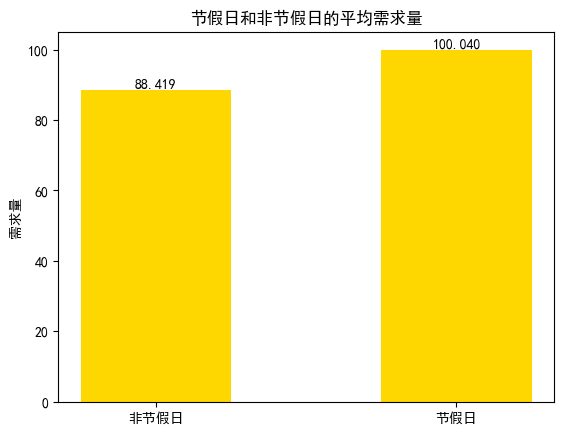

In [63]:
holiday_data=data[['is_holiday','ord_qty']].groupby('is_holiday').mean()
holiday_y=holiday_data['ord_qty']
holiday_data
plt.bar(['非节假日','节假日'],holiday_y,color=colors[0],width=0.5)
plt.ylabel('需求量')
plt.title("节假日和非节假日的平均需求量")
for x,y in zip(['非节假日','节假日'],holiday_y):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()


### 大类的平均需求量

8 8
[301, 302, 303, 304, 305, 306, 307, 308] [301, 302, 303, 304, 305, 306, 307, 308]
[67, 63, 52, 54, 79, 109, 105, 103] [85, 70, 54, 70, 94, 117, 124, 140]


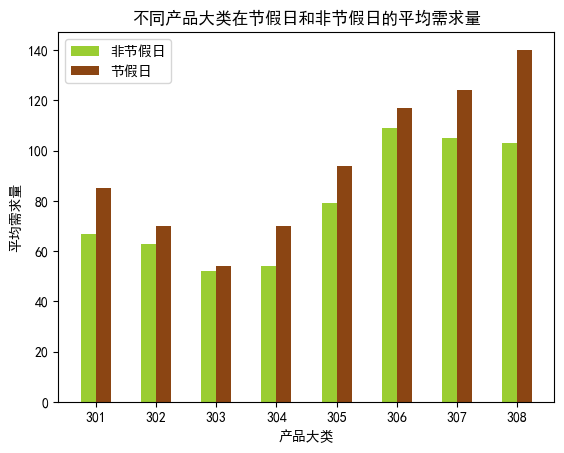

In [80]:
holiday_data_first=data[['is_holiday','first_cate_code','ord_qty']].groupby(['is_holiday','first_cate_code'],as_index=False).mean()
x_first_0=first_cate_code_list
x_first_1=first_cate_code_list
# print(x_first)
y_first_0=[0 for i in range(first_cate_len)]
y_first_1=[0 for i in range(first_cate_len)]
for index,item in holiday_data_first.iterrows():
    boolean=item['is_holiday']
    cate_code=str(int(item['first_cate_code']))
    qty=int(item['ord_qty'])
    if(boolean==0):
        y_first_0[first_cate_code_dict[cate_code]]=qty
    elif(boolean==1):
         y_first_1[first_cate_code_dict[cate_code]]=qty
    # print(chann,cate_code,qty)
    # print(chann)
print(len(x_first_0),len(x_first_1))
print(x_first_0,x_first_1)
print(y_first_0,y_first_1)
wid=0.25
x=2
# plt.bar(x_first_0,y_first_0)
# plt.bar(x_first_1,y_first_1)
x = np.arange(len(x_first_0))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, y_first_0, width, label='非节假日',color=colors[2])
plt.bar(x + width/2, y_first_1, width, label='节假日',color=colors[1])
plt.xticks(x,x_first_0)
plt.ylabel("平均需求量")
plt.xlabel("产品大类")
plt.title("不同产品大类在节假日和非节假日的平均需求量")
plt.legend()
plt.show()

### 细类的平均需求量

12 12
[401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412] [401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]
[60, 187, 105, 103, 67, 8, 105, 63, 54, 14, 9, 79] [61, 196, 124, 140, 85, 8, 112, 70, 70, 14, 9, 94]


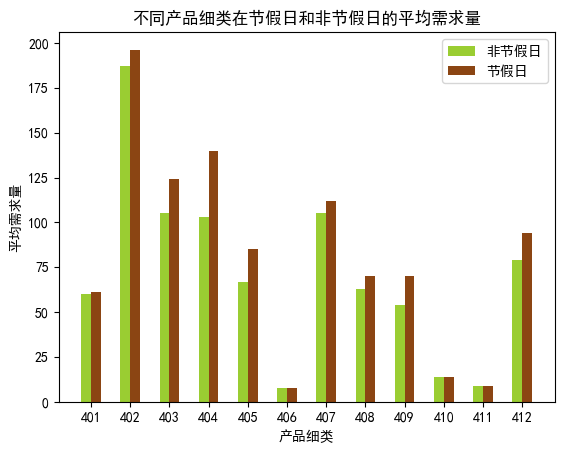

In [78]:
holiday_data_second=data[['is_holiday','second_cate_code','ord_qty']].groupby(['is_holiday','second_cate_code'],as_index=False).mean()
x_second_0=second_cate_code_list
x_second_1=second_cate_code_list
# print(x_second)
y_second_0=[0 for i in range(second_cate_len)]
y_second_1=[0 for i in range(second_cate_len)]
for index,item in holiday_data_second.iterrows():
    boolean=item['is_holiday']
    cate_code=str(int(item['second_cate_code']))
    qty=int(item['ord_qty'])
    if(boolean==0):
        y_second_0[second_cate_code_dict[cate_code]]=qty
    elif(boolean==1):
         y_second_1[second_cate_code_dict[cate_code]]=qty
    # print(chann,cate_code,qty)
    # print(chann)
print(len(x_second_0),len(x_second_1))
print(x_second_0,x_second_1)
print(y_second_0,y_second_1)
wid=0.25
x=2
# plt.bar(x_second_0,y_second_0)
# plt.bar(x_second_1,y_second_1)
x = np.arange(len(x_second_0))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
# x - width/2，x + width/2即每组数据在x轴上的位置
plt.bar(x - width/2, y_second_0, width, label='非节假日',color=colors[2])
plt.bar(x + width/2, y_second_1, width, label='节假日',color=colors[1])
plt.xticks(x,x_second_0)
plt.ylabel("平均需求量")
plt.xlabel("产品细类")
plt.title("不同产品细类在节假日和非节假日的平均需求量")
plt.legend()
plt.show()

# 季节因素对产品需求量的影响。

不同季节的平均需求量，由于2015只有下半年，故不能求总量

In [64]:
season_dict={1:'春天',2:'夏天',3:'秋天',4:"冬天"}

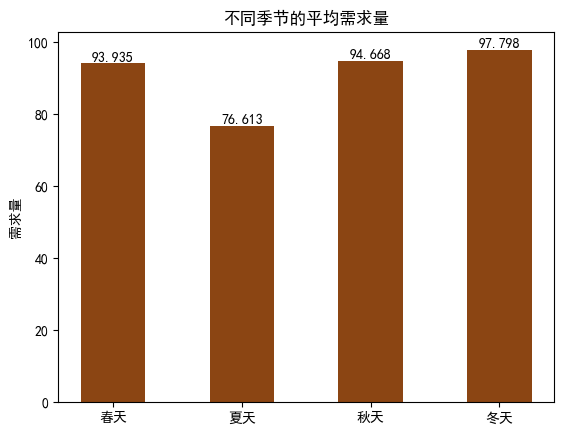

In [65]:
season_data=data[['season','ord_qty']].groupby('season',as_index=False).mean()
season_y=season_data['ord_qty']
season_x=list(season_data['season'])
season_x=[season_dict[int(i)] for i in season_x]
# season_data
plt.bar(season_x,season_y,color=colors[1],width=0.5)
plt.ylabel('需求量')
plt.title("不同季节的平均需求量")
for x,y in zip(season_x,season_y):
    plt.text(x,y,'%.3f'%y,ha='center',va='bottom',fontsize=10)
plt.show()


各产品大类、细类不同季节的平均需求量

各年份每个月份的需求量情况
